In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from pathlib import Path
from scipy.special import rel_entr, kl_div
from scipy.stats import wasserstein_distance

parameter_names = ['cpa', 'pwr1par', 'pwr2par', 'pwr1perr', 'pwr2perr'] 
PARAMETERS_MIN = np.array([100., 0.4, 0.4, 0.4, 0.4]) 
PARAMETERS_MAX = np.array([870., 1.7, 1.7, 2.3, 2.3]) 

## Relevant functions from utils.py
Can't just import utils since path to data is different than utils.py

In [2]:
def index_mcmc_runs(file_version):
    """Make a list of combinations for which we want to run MCMC."""
    if file_version == '2023':
        experiments = ['AMS02_H-PRL2021', 'PAMELA_H-ApJ2013', 'PAMELA_H-ApJL2018']
        dfs = []
        for experiment_name in experiments:
            filename = f'../../data/2023/{experiment_name}_heliosphere.dat'
            df = index_experiment_files(filename) 
            df['experiment_name'] = experiment_name
            df['filename_heliosphere'] = filename
            dfs.append(df)
        df = pd.concat(dfs, axis=0, ignore_index=0)

    elif file_version == '2024':
        filename = f'../../data/2024/yearly_heliosphere.dat'
        df = read_experiment_summary(filename)
        df['experiment_name'] = 'yearly'
        df['filename_heliosphere'] = filename

    else: raise ValueError(f"Unknown file_version {file_version}. Must be '2023' or '2024'.")

    return df

def read_experiment_summary(filename) -> pd.DataFrame:
    """
    Read .dat filename that describes experimental conditions during time intervals.
    """
    if '2023' in filename: file_version = '2023'
    elif '2024' in filename: file_version = '2024'
    else: raise ValueError(f"Unknown file_version {file_version}. Must be '2023' or '2024'.")

    if file_version == '2023':
        # Header reads "time interval; alpha avg; cmf avg; vspoles avg; alpha std; cmf std; vspoles std"
        df = pd.read_csv(filename, sep=' ', skiprows=1, names=['interval', 'alpha', 'cmf', 'vspoles', 'alpha_std', 'cmf_std', 'vspoles_std'])
    
        # Parse interval
        df['beginning'] = df.interval.apply(lambda x: pd.to_datetime(x.split('-')[0], format='%Y%m%d'))
        df['ending'] = df.interval.apply(lambda x: pd.to_datetime(x.split('-')[0], format='%Y%m%d'))

    elif file_version == '2024':
        # Header reads "time interval; alpha avg; cmf avg; vspoles avg; alpha std; cmf std; vspoles std; polarity"
        df_full = pd.read_csv(filename, sep=' ', skiprows=1, names=['interval', 'alpha', 'cmf', 'vspoles', 'alpha_std', 'cmf_std', 'vspoles_std', 'polarity'])

        # only use the neg or neg,pos polarities column, and change all to be neg
        df = df_full[df_full['polarity'].str.contains('neg')].copy(deep=True)
        df['polarity'] = 'neg'

    return df

def index_experiment_files(filename)->pd.DataFrame:
    """Create list of experiments that need to be done. 
    Note this is only needed for file_version '2023'
    filename = f'../../data/2023/{EXPERIMENT_NAME}_heliosphere.dat'
    """
    df = read_experiment_summary(filename)
    # The datasets to be fitted are: PAMELA_H-ApJ2013, PAMELA_H-ApJL2018, and AMS02_H-PRL2021.
    # You should use the neg models for data files up to February 2015, and the pos models for data files from October 2013.
    # So, between October 2013 and February 2015, the data files should be fitted independently with both neg and pos models.
    # All PAMELA files are before February 2015, so only neg models for them.
    # For AMS02 files, 20130925-20131021.dat is the first file to be fitted with pos models, while 20150124-20150219.dat is the last file to be fitted with neg models.
    # 
    # For PAMELA_H-ApJL2018, the files 20130928-20131025.dat, 20131121-20131219.dat, and 20140115-20140211.dat should be fit independently with both neg and pos models.

    dfneg = df[df.beginning < pd.to_datetime('March 1 2015')].copy(deep=True)
    dfneg['polarity'] = 'neg'

    dfpos = df[df.ending >= pd.to_datetime('October 1 2013')].copy(deep=True)
    dfpos['polarity'] = 'pos'

    # rval = pd.concat([dfneg, dfpos], axis=0, ignore_index=True)
    rval = dfneg # Only fitting negative models for now.
    
    return rval

def get_distance(hist_0, hist_1, metric='mae'):
    """
    Compute distance between two histograms.
    """
    num_bins = len(hist_0)
    if len(hist_1) != num_bins:
        raise ValueError(f"Histograms must have the same number of bins. {len(hist_0)} != {len(hist_1)}")
    
    if metric == 'mae':
        return np.abs(hist_0 - hist_1).sum() / num_bins
    elif metric == 'mse':
        return ((hist_0 - hist_1) ** 2).sum() / num_bins
    elif metric == 'kl':
        return kl_div(hist_0, hist_1).sum()
    elif metric == 'wasserstein':
        return wasserstein_distance(hist_0, hist_1)
    else:
        raise ValueError(f"Unknown metric {metric}.")

## Individual run

In [ ]:
data_version=['d1', 'd2'] # 'd1', 'd2'
bootstrap=['b0', 'b1'] # 'b0' or 'b1', false or true
model_version=['init1', 'init2'] # 'init1' or 'init2'
hmc_run = ['hmc1', 'hmc2'] # 'hmc1' or 'hmc2'
regularizer = '1e-5' # ['1e-1', '1e-2', '1e-3', '1e-4', '1e-5']

# Parameters (change me!)
idx = 24 # 24 corresponds to 20130221-20130319, the interval in the paper
train_size_fraction = 1.0
hmc_version='v30'
data_bootstrap_model_hmc_identifier_0 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
data_bootstrap_model_hmc_identifier_1 = f"{data_version[1]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
data_bootstrap_model_hmc_identifier_2 = f"{data_version[0]}_{bootstrap[1]}_{model_version[1]}_{hmc_run[0]}"
data_bootstrap_model_hmc_identifier_3 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[1]}"

# # Load relevant HMC results
print(f"Comparing {data_bootstrap_model_hmc_identifier_0}, {data_bootstrap_model_hmc_identifier_1}, {data_bootstrap_model_hmc_identifier_2}, and {data_bootstrap_model_hmc_identifier_3} for train size fraction {train_size_fraction} and regularizer {regularizer}.")
# results_dir_hmc_0 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_0}_{regularizer}_{train_size_fraction}/"
# results_dir_hmc_1 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_1}_{regularizer}_{train_size_fraction}/"
# results_dir_hmc_2 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_2}_{regularizer}_{train_size_fraction}/"
# results_dir_hmc_3 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_3}_{regularizer}_{train_size_fraction}/"
results_dir_hmc_0 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_0}_{train_size_fraction}_{regularizer}/"
results_dir_hmc_1 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_1}_{train_size_fraction}_{regularizer}/"
results_dir_hmc_2 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_2}_{train_size_fraction}_{regularizer}/"
# results_dir_hmc_2 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_3}_{train_size_fraction}_{regularizer}/"

# Get interval corresponding to one in paper
df = index_mcmc_runs(file_version='2023')
df_int = df.iloc[idx:idx+1].copy(deep=True)
interval = df_int.interval.iloc[0]
polarity = df_int.polarity.iloc[0]
exp_name = df_int.experiment_name.iloc[0]
print(f"Interval {interval} corresponds to index {idx} for {polarity} polarity in {exp_name}.")
df_int.head()

# Load the samples from each hmc run
# They are stored like this: f'{results_dir_hmc}.0/samples_{idx}_{df.experiment_name}_{df.interval}_{df.polarity}.csv'
# csv file has no headers, but samples are in this order: ['cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr']
hmc_0_samples = pd.read_csv(f'{results_dir_hmc_0}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
hmc_1_samples = pd.read_csv(f'{results_dir_hmc_1}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
hmc_2_samples = pd.read_csv(f'{results_dir_hmc_2}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
# hmc_3_samples = pd.read_csv(f'{results_dir_hmc_3}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')

parameter_names = ['cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr']
hmc_0_samples.columns = parameter_names
hmc_1_samples.columns = parameter_names
hmc_2_samples.columns = parameter_names
# hmc_3_samples.columns = parameter_names

Interval 20130221-20130319 corresponds to index 24 for neg polarity in AMS02_H-PRL2021.


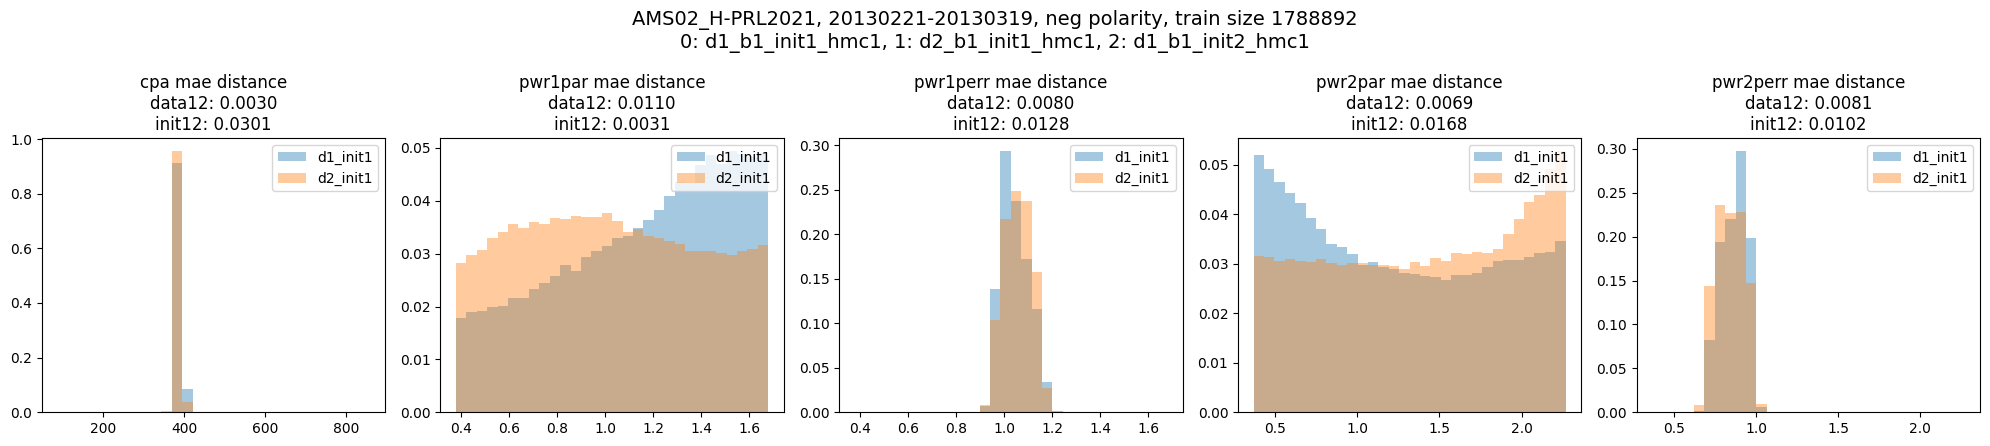

In [ ]:
num_bins = 30
metric = 'mae' # 'mae', 'mse', 'kl', or 'wasserstein'

# Let's make a 1 x 5 grid of subplots, where they are the historograms of the samples. We'll plot both hmc_0 and hmc_1 samples in the same grid
fig, axs = plt.subplots(1, 5, figsize=(20, 4.5))
# plt.suptitle(f"{exp_name}, {interval}, {polarity} polarity, train size {int(train_size_fraction * 1_788_892)}\n0: {data_bootstrap_model_hmc_identifier_0}, 1: {data_bootstrap_model_hmc_identifier_1}\n2: {data_bootstrap_model_hmc_identifier_2}, 3: {data_bootstrap_model_hmc_identifier_3}", fontsize=14)
plt.suptitle(f"{exp_name}, {interval}, {polarity} polarity, train size {int(train_size_fraction * 1_788_892)}\n0: {data_bootstrap_model_hmc_identifier_0}, 1: {data_bootstrap_model_hmc_identifier_1}, 2: {data_bootstrap_model_hmc_identifier_2}", fontsize=14)
# Plot the samples
distances = []
for i, param in enumerate(parameter_names):
    samples_0 = hmc_0_samples[param].values
    samples_1 = hmc_1_samples[param].values
    samples_2 = hmc_2_samples[param].values
    # samples_3 = hmc_3_samples[param].values

    # Plot the samples with same bins
    # Use global binning after lab meeting conversation 4/9/2025
    min = PARAMETERS_MIN[i] 
    max = PARAMETERS_MAX[i]

    # Create histograms and plot
    hist_0, bins = np.histogram(samples_0, bins=num_bins, range=(min, max), density=True)
    hist_1, bins = np.histogram(samples_1, bins=num_bins, range=(min, max), density=True)
    hist_2, bins = np.histogram(samples_2, bins=num_bins, range=(min, max), density=True)
    # hist_3, bins = np.histogram(samples_3, bins=num_bins, range=(min, max), density=True)

    # Normalize the histograms
    hist_0 /= hist_0.sum()
    hist_1 /= hist_1.sum()
    hist_2 /= hist_2.sum()
    # hist_3 /= hist_3.sum()

    # Compute distance as MAE between bins
    distance_01 = get_distance(hist_0, hist_1, metric)
    distance_02 = get_distance(hist_0, hist_2, metric)
    # distance_03 = get_distance(hist_0, hist_3, metric)

    # Plot the histograms
    axs[i].bar(bins[:-1], hist_0, width=(bins[1]-bins[0]), alpha=0.4, label='d1_init1')
    axs[i].bar(bins[:-1], hist_1, width=(bins[1]-bins[0]), alpha=0.4, label='d2_init1')
    # axs[i].bar(bins[:-1], hist_2, width=(bins[1]-bins[0]), alpha=0.4, label='d1_init2')

    # Set the title and labels
    # axs[i].set_title(f"{param} {metric} distance\n0-1: {distance_01:.4f}\n0-2: {distance_02:.4f}\n0-3: {distance_03:.4f}")
    axs[i].set_title(f"{param} {metric} distance\ndata12: {distance_01:.4f}\ninit12: {distance_02:.4f}")
    axs[i].legend(loc='upper right')

plt.tight_layout()
plt.savefig(f'../../../results/{hmc_version}/plots/{data_bootstrap_model_hmc_identifier_0}_vs_{data_bootstrap_model_hmc_identifier_2}_{regularizer}_{train_size_fraction}_{idx}_samples.png', dpi=300)
# plt.savefig(f'../../../results/{hmc_version}/plots/{data_bootstrap_model_hmc_identifier_0}_vs_all_{regularizer}_{train_size_fraction}_{idx}_samples.png', dpi=300)
plt.show()

## All the train sizes

In [12]:
# Parameters (change me!)
regularizer = '1e-5' # ['1e-1', '1e-2', '1e-3', '1e-4', '1e-5']
hmc_version='v30'
# data_bootstrap_model_hmc_identifier_0 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}_{regularizer}"
# data_bootstrap_model_hmc_identifier_1 = f"{data_version[1]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}_{regularizer}"
# data_bootstrap_model_hmc_identifier_2 = f"{data_version[0]}_{bootstrap[1]}_{model_version[1]}_{hmc_run[0]}_{regularizer}"
# data_bootstrap_model_hmc_identifier_3 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[1]}_{regularizer}"
data_bootstrap_model_hmc_identifier_0 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
data_bootstrap_model_hmc_identifier_1 = f"{data_version[1]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
data_bootstrap_model_hmc_identifier_2 = f"{data_version[0]}_{bootstrap[1]}_{model_version[1]}_{hmc_run[0]}"
idx = 100 # 24 corresponds to 20130221-20130319, the interval in the paper
num_bins = 30
metric = 'mae' # 'mae', 'mse', 'kl', or 'wasserstein'

# Get values
df = index_mcmc_runs(file_version='2023')
df_int = df.iloc[idx:idx+1].copy(deep=True)
interval = df_int.interval.iloc[0]
polarity = df_int.polarity.iloc[0]
exp_name = df_int.experiment_name.iloc[0]
# train_fractions = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
train_fractions = [0.1, 0.5, 1.0]

distances_01 = {}
distances_02 = {}
# distances_03 = {}
for param in parameter_names:
    distances_01[param] = []
    distances_02[param] = []
    # distances_03[param] = []

# Calculate the distance for each parameter and train size
for i, train_size_fraction in enumerate(train_fractions):
    # Parameters (change me!)
    # results_dir_hmc_0 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_0}_{train_size_fraction}/"
    # results_dir_hmc_1 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_1}_{train_size_fraction}/"
    # results_dir_hmc_2 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_2}_{train_size_fraction}/"
    # results_dir_hmc_3 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_3}_{train_size_fraction}/"
    results_dir_hmc_0 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_0}_{train_size_fraction}_{regularizer}/"
    results_dir_hmc_1 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_1}_{train_size_fraction}_{regularizer}/"
    results_dir_hmc_2 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_2}_{train_size_fraction}_{regularizer}/"

    # Load the samples from each hmc run
    # They are stored like this: f'{results_dir_hmc}.0/samples_{idx}_{df.experiment_name}_{df.interval}_{df.polarity}.csv'
    # csv file has no headersd, but samples are in this order: ['cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr']
    hmc_0_samples = pd.read_csv(f'{results_dir_hmc_0}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
    hmc_1_samples = pd.read_csv(f'{results_dir_hmc_1}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
    hmc_2_samples = pd.read_csv(f'{results_dir_hmc_2}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
    # hmc_3_samples = pd.read_csv(f'{results_dir_hmc_3}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')

    hmc_0_samples.columns = parameter_names
    hmc_1_samples.columns = parameter_names
    hmc_2_samples.columns = parameter_names
    # hmc_3_samples.columns = parameter_names

    for j, param in enumerate(parameter_names):
        samples_0 = hmc_0_samples[param].values
        samples_1 = hmc_1_samples[param].values
        samples_2 = hmc_2_samples[param].values
        # samples_3 = hmc_3_samples[param].values

        # Plot the samples with same bins
        # Use global binning after lab meeting conversation 4/9/2025
        min = PARAMETERS_MIN[j] 
        max = PARAMETERS_MAX[j]

        # Create histograms and plot
        hist_0, bins = np.histogram(samples_0, bins=num_bins, range=(min, max), density=True)
        hist_1, bins = np.histogram(samples_1, bins=num_bins, range=(min, max), density=True)
        hist_2, bins = np.histogram(samples_2, bins=num_bins, range=(min, max), density=True)
        # hist_3, bins = np.histogram(samples_3, bins=num_bins, range=(min, max), density=True)

        # Normalize the histograms
        hist_0 /= hist_0.sum()
        hist_1 /= hist_1.sum()
        hist_2 /= hist_2.sum()
        # hist_3 /= hist_3.sum()

        # Calculate distance as MAE between bins
        distance_01 = get_distance(hist_0, hist_1, metric)
        distance_02 = get_distance(hist_0, hist_2, metric)
        # distance_03 = get_distance(hist_0, hist_3, metric)

        distances_01[param].append(distance_01)
        distances_02[param].append(distance_02)
        # distances_03[param].append(distance_03)

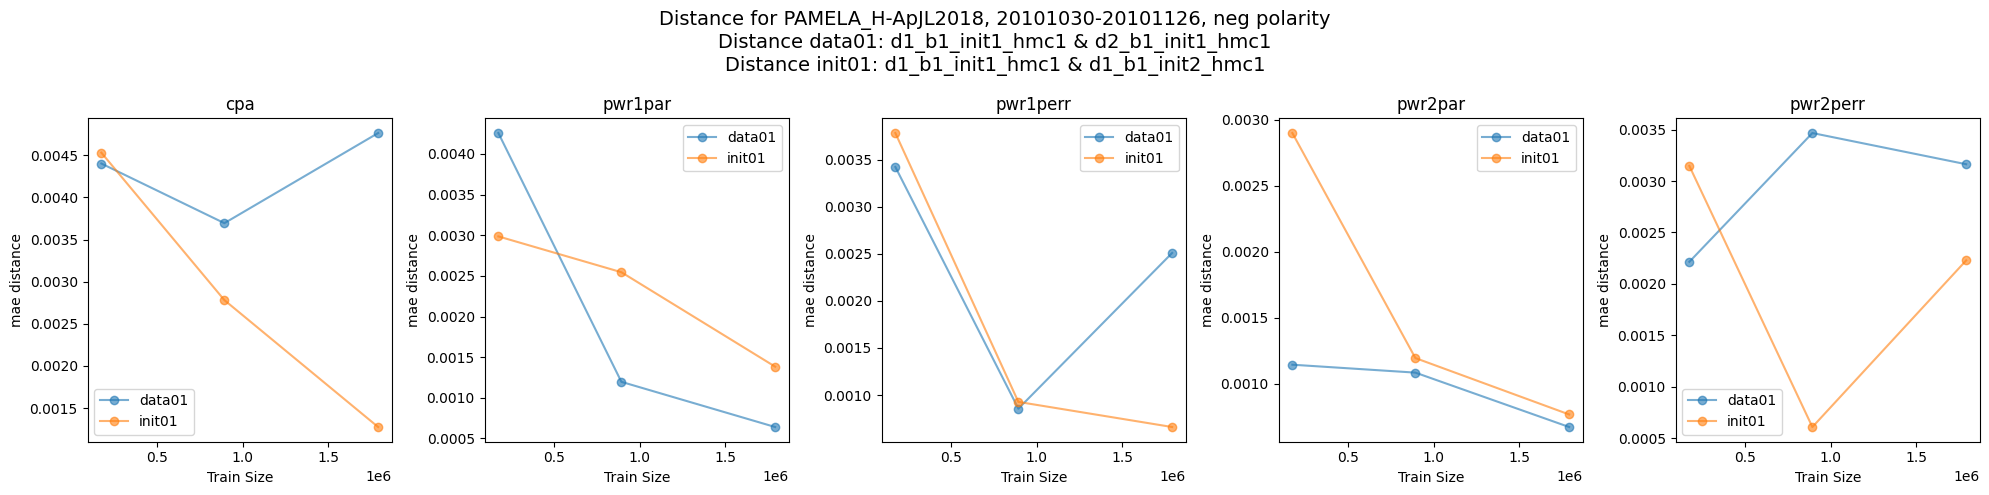

In [13]:
# Let's make a 1 x 5 grid of subplots, where each plot is the distance metric for each parameter over all the train sizes
plt.figure(figsize=(20, 5))
# plt.suptitle(f"Distance for {exp_name}, {interval}, {polarity} polarity\nDistance hmc01: {data_bootstrap_model_hmc_identifier_0} & {data_bootstrap_model_hmc_identifier_3}\nDistance data01: {data_bootstrap_model_hmc_identifier_0} & {data_bootstrap_model_hmc_identifier_1}\nDistance init01: {data_bootstrap_model_hmc_identifier_0} & {data_bootstrap_model_hmc_identifier_2}", fontsize=14)
plt.suptitle(f"Distance for {exp_name}, {interval}, {polarity} polarity\nDistance data01: {data_bootstrap_model_hmc_identifier_0} & {data_bootstrap_model_hmc_identifier_1}\nDistance init01: {data_bootstrap_model_hmc_identifier_0} & {data_bootstrap_model_hmc_identifier_2}", fontsize=14)
data_train_fractions = np.array(train_fractions[:-1] + [1.0]) * 1_788_892 # Scale to the number of data points in the full dataset

# Plot the KL divergences
for i, param in enumerate(parameter_names):
    plt.subplot(1, 5, i+1)
    # plt.plot(data_train_fractions, distances_03[param], marker='o', alpha=0.6, label='hmc01')
    plt.plot(data_train_fractions, distances_01[param], marker='o', alpha=0.6, label='data01')
    plt.plot(data_train_fractions, distances_02[param], marker='o', alpha=0.6, label='init01')
    plt.title(param)
    plt.xlabel('Train Size')
    plt.ylabel(f'{metric} distance')
    plt.legend()

plt.tight_layout()
plt.savefig(f'../../../results/{hmc_version}/plots/{data_bootstrap_model_hmc_identifier_0}_vs_all_{idx}_{metric}_distance.png', dpi=300)
plt.show()

## All the runs

In [31]:
# Parameters (change me!)
data_bootstrap_model_hmc_identifier_0 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
data_bootstrap_model_hmc_identifier_1 = f"{data_version[1]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
train_size_fraction = 1.0
num_bins = 30
hmc_version = 'v30'
regularizer = '1e-4' # ['1e-1', '1e-2', '1e-3', '1e-4', '1e-5']
metric = 'mae' # 'mae', 'mse', 'kl', or 'wasserstein'

# Get values
df_idxs = range(len(df))
distances = {}
for param in parameter_names:
    distances[param] = []

# Calculate the distance for each parameter and train size
for i, idx in enumerate(df_idxs):
    # Parameters (change me!)
    results_dir_hmc_0 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_0}_{train_size_fraction}_{regularizer}/"
    results_dir_hmc_1 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_1}_{train_size_fraction}_{regularizer}/"

    # Load the samples from each hmc run
    # They are stored like this: f'{results_dir_hmc}.0/samples_{idx}_{df.experiment_name}_{df.interval}_{df.polarity}.csv'
    # csv file has no headersd, but samples are in this order: ['cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr']
    exp_name = df.experiment_name.iloc[idx]
    interval = df.interval.iloc[idx]
    polarity = df.polarity.iloc[idx]
    hmc_0_samples = pd.read_csv(f'{results_dir_hmc_0}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
    hmc_1_samples = pd.read_csv(f'{results_dir_hmc_1}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')

    hmc_0_samples.columns = parameter_names
    hmc_1_samples.columns = parameter_names

    for j, param in enumerate(parameter_names):
        samples_0 = hmc_0_samples[param].values
        samples_1 = hmc_1_samples[param].values

        # Plot the samples with same bins
        # Use global binning after lab meeting conversation 4/9/2025
        min = PARAMETERS_MIN[j] 
        max = PARAMETERS_MAX[j]

        # Create histograms and plot
        hist_0, bins = np.histogram(samples_0, bins=num_bins, range=(min, max), density=True)
        hist_1, bins = np.histogram(samples_1, bins=num_bins, range=(min, max), density=True)

        # Normalize the histograms
        hist_0 /= hist_0.sum()
        hist_1 /= hist_1.sum()

        # Calculate distance as MAE between bins
        distance = get_distance(hist_0, hist_1, metric)
        distances[param].append(distance)

FileNotFoundError: [Errno 2] No such file or directory: '../../../results/v30/d1_b1_init1_hmc1_1.0_1e-4/samples_0_AMS02_H-PRL2021_20110520-20110610_neg.csv'

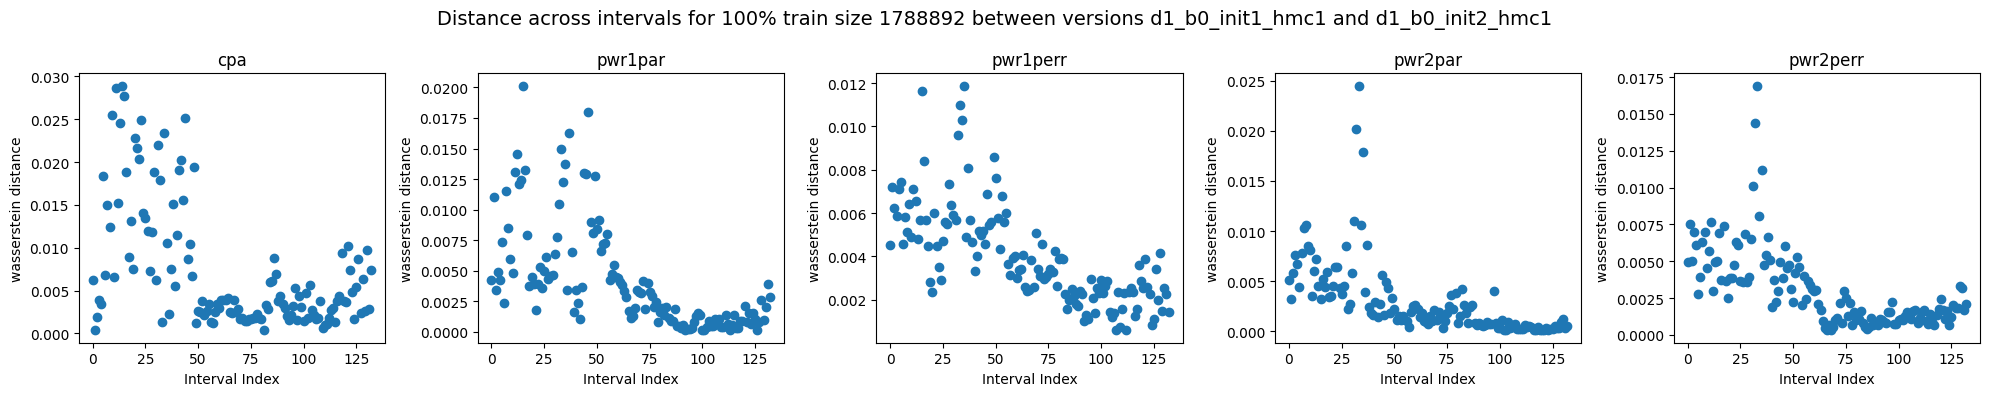

In [28]:
# Let's make a 1 x 5 grid of subplots, where each plot is the kl_divergence for each parameter over all the train sizes
plt.figure(figsize=(20, 4))
plt.suptitle(f"Distance across intervals for {int(train_size_fraction * 100)}% train size {int(train_size_fraction * 1_788_892)} between versions {data_bootstrap_model_hmc_identifier_0} and {data_bootstrap_model_hmc_identifier_1}", fontsize=14)

# Plot the KL divergences
for i, param in enumerate(parameter_names):
    plt.subplot(1, 5, i+1)
    plt.scatter(df_idxs, distances[param], marker='o')
    plt.title(param)
    plt.xlabel('Interval Index')
    plt.ylabel(f'{metric} distance')

plt.tight_layout()
plt.savefig(f'../../../results/{hmc_version}/plots/{data_bootstrap_model_hmc_identifier_0}_vs_{data_bootstrap_model_hmc_identifier_1}_{train_size_fraction}_{metric}_distance.png', dpi=300)
plt.show()